In [ ]:
!pip install -U -q PyDrive

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [7]:
file_id = '1XseCwZypO9MK5T7Ty3o0ljoG8PxmbIcMF5MvOkoP4iM'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('Movie_Data_File.csv', mimetype='text/csv')

In [8]:
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from wordcloud import WordCloud
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from scipy.sparse import save_npz

#Import Dataset

In [10]:
df = pd.read_csv("/content/Movie_Data_File.csv")

In [11]:
df.head()

,Film_title,Release_year,Director,Cast,Average_rating,Owner_rating,Genres,Runtime,Countries,Original_language,...,★½,★★,★★½,★★★,★★★½,★★★★,★★★★½,★★★★★,Total_ratings,Film_URL
0,The Fan,NaN,Eckhart Schmidt,"['Désirée Nosbusch', 'Bodo Staiger', 'Simone B...",3.57,NaN,"['Horror', 'Drama']",92.0,['Germany'],German,...,103,402,525,1660,1950,2646,808,714,9042,https://letterboxd.com/film/the-fan-1982/
1,Mad Max: Fury Road,NaN,George Miller,"['Tom Hardy', 'Charlize Theron', 'Nicholas Hou...",4.18,4.5,"['Adventure', 'Science Fiction', 'Action']",121.0,"['Australia', 'USA']",English,...,6139,37471,30112,158356,163753,477901,280815,511140,1682389,https://letterboxd.com/film/mad-max-fury-road/
2,Suspiria,NaN,Dario Argento,"['Jessica Harper', 'Stefania Casini', 'Flavio ...",3.93,4.0,['Horror'],99.0,['Italy'],English,...,2710,11006,14397,53427,70309,138742,60628,88628,443757,https://letterboxd.com/film/suspiria/
3,Lost in Translation,NaN,Sofia Coppola,"['Bill Murray', 'Scarlett Johansson', 'Akiko T...",3.79,4.5,"['Drama', 'Comedy', 'Romance']",102.0,"['UK', 'USA']",English,...,11281,45997,46716,155110,166638,314160,122359,193717,1076949,https://letterboxd.com/film/lost-in-translation/
4,Akira,NaN,Katsuhiro Otomo,"['Mitsuo Iwata', 'Nozomu Sasaki', 'Mami Koyama...",4.28,5.0,"['Animation', 'Action', 'Science Fiction']",124.0,['Japan'],Japanese,...,1663,7286,9544,40850,61104,168485,112657,196532,600721,https://letterboxd.com/film/akira/


#Data Preprocessing

In [12]:
#check NaN data
df.isnull().sum()

,0
Film_title,0
Release_year,10002
Director,10
Cast,57
Average_rating,581
Owner_rating,9035
Genres,24
Runtime,10
Countries,118
Original_language,3


In [13]:
#check duplicate
df.duplicated().sum()

np.int64(31)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10002 entries, 0 to 10001
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Film_title         10002 non-null  object 
 1   Release_year       0 non-null      float64
 2   Director           9992 non-null   object 
 3   Cast               9945 non-null   object 
 4   Average_rating     9421 non-null   float64
 5   Owner_rating       967 non-null    float64
 6   Genres             9978 non-null   object 
 7   Runtime            9992 non-null   float64
 8   Countries          9884 non-null   object 
 9   Original_language  9999 non-null   object 
 10  Spoken_languages   9999 non-null   object 
 11  Description        10000 non-null  object 
 12  Studios            9695 non-null   object 
 13  Watches            10002 non-null  int64  
 14  List_appearances   10002 non-null  int64  
 15  Likes              10002 non-null  int64  
 16  Fans               100

In [15]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Film_title,10002,9667,Hercules,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Release_year,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Director,9992,4763,Chuck Jones,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cast,9945,9878,['Mel Blanc'],18,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Average_rating,9421.0,NaN,NaN,NaN,3.268535,0.54166,1.08,2.92,3.3,3.65,4.71
Owner_rating,967.0,NaN,NaN,NaN,2.98759,0.903954,0.5,2.5,3.0,3.5,5.0
Genres,9978,2396,['Drama'],759,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Runtime,9992.0,NaN,NaN,NaN,103.168335,38.08611,2.0,89.0,99.0,113.0,907.0
Countries,9884,857,['USA'],5408,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Original_language,9999,56,English,8075,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# Replace the line causing the error with these lines:
for column in ['Release_year', 'Runtime', 'Owner_rating', 'Average_rating']:
    # You might want to replace '' with a more suitable value
    # like the mean or median for numerical columns.
    df[column].fillna('', inplace=True)

<ipython-input-16-379430782>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna('', inplace=True)
<ipython-input-16-379430782>:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df[column].fillna('', inplace=True)


In [17]:
import plotly.graph_objects as go
import plotly.express as px

movie_type_counts = df['Studios'].value_counts()

# Group smaller genres into "Other"
threshold = 15  # Adjust as needed
other_count = movie_type_counts[movie_type_counts >= threshold].sum()
movie_type_counts = movie_type_counts[movie_type_counts >= threshold]
movie_type_counts['Other'] = other_count

fig = go.Figure(data=go.Pie(labels=movie_type_counts.index, values=movie_type_counts.values, hole=0.3))

fig.update_layout(
    plot_bgcolor='rgb(17, 17, 17)',
    paper_bgcolor='rgb(17, 17, 17)',
    font_color='white',
    title='Top Studios With Highest Number Of Films Production',
    title_font_size=20,
    legend_font_size=12,
    showlegend=True
)

fig.update_traces(
    textinfo='percent+label',  # Display percentage and label
    textposition='inside',      # Position text inside the slices
    insidetextorientation='radial',
    marker=dict(colors=px.colors.qualitative.Set1)  # Apply color sequence
)

fig.show()

In [18]:
top_countries = df['Countries'].value_counts().head(10)

fig = px.treemap(names=top_countries.index, parents=["" for _ in top_countries.index], values=top_countries.values)

fig.update_layout(
    plot_bgcolor='rgb(17, 17, 17)',
    paper_bgcolor='rgb(17, 17, 17)',
    font_color='white',
    title='Top Countries with Highest Number of Movies',
)
fig.show()

In [19]:
import plotly.express as px

fig = px.histogram(df, x="Average_rating", nbins=100)  # Adjust nbins as needed
fig.update_layout(title="Movie Average Ratings Distribution")
fig.show()

In [20]:
import plotly.express as px

fig = px.histogram(df, x="Runtime", nbins=100)  # Adjust nbins as needed
fig.update_layout(title="Movie Duration")
fig.show()

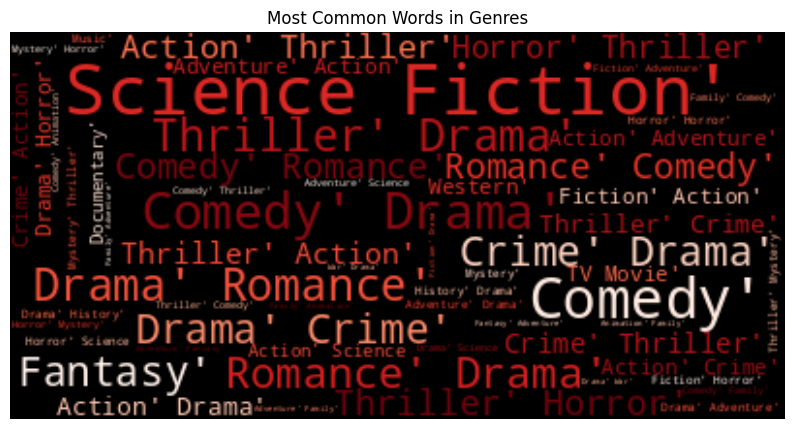

In [22]:
titles = df['Genres'].values

text = ' '.join(titles.astype(str))

wordcloud = WordCloud(background_color='black', colormap='Reds').generate(text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Genres', color='black')
plt.show()

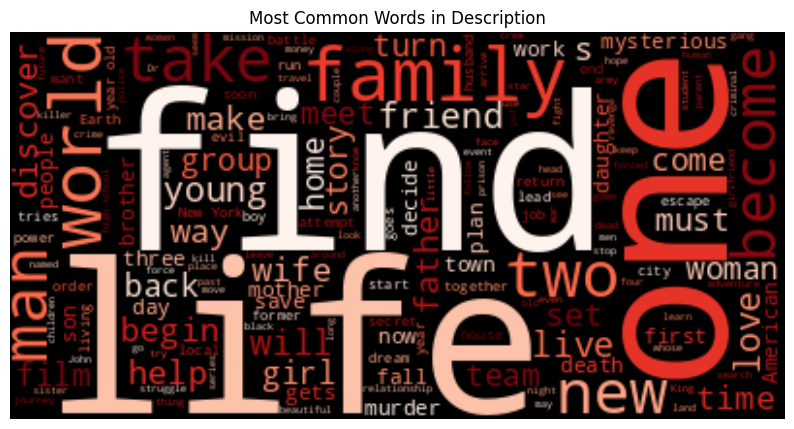

In [23]:
titles = df['Description'].values

text = ' '.join(titles.astype(str))

wordcloud = WordCloud(background_color='black', colormap='Reds').generate(text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Description', color='black')
plt.show()

#Featuring Data

In [24]:
new_data = df[['Film_title', 'Genres', 'Director', 'Cast', 'Countries', 'Original_language', 'Description','Studios','Spoken_languages']]
new_data.set_index('Film_title', inplace=True)

In [25]:
new_data.head()

,Genres,Director,Cast,Countries,Original_language,Description,Studios,Spoken_languages
Film_title,,,,,,,,
The Fan,"['Horror', 'Drama']",Eckhart Schmidt,"['Désirée Nosbusch', 'Bodo Staiger', 'Simone B...",['Germany'],German,The hero-worship that Simone has for a pop sin...,['Barbara Moorse Workshop'],['German']
Mad Max: Fury Road,"['Adventure', 'Science Fiction', 'Action']",George Miller,"['Tom Hardy', 'Charlize Theron', 'Nicholas Hou...","['Australia', 'USA']",English,An apocalyptic story set in the furthest reach...,"['Warner Bros. Pictures', 'Village Roadshow Pi...",['English']
Suspiria,['Horror'],Dario Argento,"['Jessica Harper', 'Stefania Casini', 'Flavio ...",['Italy'],English,An American newcomer to a prestigious German b...,['Seda Spettacoli'],"['English', 'French', 'German', 'Italian', 'La..."
Lost in Translation,"['Drama', 'Comedy', 'Romance']",Sofia Coppola,"['Bill Murray', 'Scarlett Johansson', 'Akiko T...","['UK', 'USA']",English,"Two lost souls visiting Tokyo -- the young, ne...","['American Zoetrope', 'Elemental Films']","['English', 'Japanese']"
Akira,"['Animation', 'Action', 'Science Fiction']",Katsuhiro Otomo,"['Mitsuo Iwata', 'Nozomu Sasaki', 'Mami Koyama...",['Japan'],Japanese,A secret military project endangers Neo-Tokyo ...,"['MBS', 'Sumitomo Corporation', 'TOHO', 'Studi...",['Japanese']


In [26]:
class TextCleaner:
    def separate_text(self, texts):
        unique_texts = set()
        for text in texts.split(','):
            unique_texts.add(text.strip().lower())
        return ' '.join(unique_texts)

    def remove_space(self, texts):
        return texts.replace(' ', '').lower()

    def remove_punc(self, texts):
        texts = texts.lower()
        texts = texts.translate(str.maketrans('', '', string.punctuation))
        return ' '.join(texts.split())

    def clean_text(self, texts):
        texts = self.separate_text(texts)
        texts = self.remove_space(texts)
        texts = self.remove_punc(texts)
        return texts

In [27]:
cleaner = TextCleaner()

In [29]:
# Access and modify the index directly:
new_data.index = new_data.index.map(cleaner.remove_space)
# The rest of your code remains the same.

# Apply the cleaning functions.
# Handle potential non-string values in columns by converting them to string first.
new_data['Director']    = new_data['Director'].astype(str).apply(cleaner.separate_text)
new_data['Countries']    = new_data['Countries'].astype(str).apply(cleaner.clean_text)
new_data['Cast']        = new_data['Cast'].astype(str).apply(cleaner.clean_text)
new_data['Genres']        = new_data['Genres'].astype(str).apply(cleaner.clean_text)
new_data['Studios']        = new_data['Studios'].astype(str).apply(cleaner.clean_text)
new_data['Spoken_languages']      = new_data['Spoken_languages'].astype(str).apply(cleaner.clean_text)
new_data['Original_language']   = new_data['Original_language'].astype(str).apply(cleaner.separate_text)
new_data['Description'] = new_data['Description'].astype(str).apply(cleaner.remove_punc)

<ipython-input-29-2109672837>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-29-2109672837>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-29-2109672837>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-29-2109672837>:1

In [30]:
new_data.head()

,Genres,Director,Cast,Countries,Original_language,Description,Studios,Spoken_languages
Film_title,,,,,,,,
thefan,dramahorror,eckhart schmidt,helgatöllechristiansimonthomasfuchsbergerwilfr...,germany,german,the heroworship that simone has for a pop sing...,barbaramoorseworkshop,german
madmax:furyroad,actionadventuresciencefiction,george miller,stephendunlevyzoëkravitzjoshhelmanhughkeaysbyr...,usaaustralia,english,an apocalyptic story set in the furthest reach...,warnerbrospictureskennedymillermitchellvillage...,english
suspiria,horror,dario argento,darianicolodilelasvastarenatazamengorudolfschü...,italy,english,an american newcomer to a prestigious german b...,sedaspettacoli,latinitalianenglishgermanfrench
lostintranslation,comedyromancedrama,sofia coppola,asukashimuzuhiromixjunmakiryuichirobabagiovann...,ukusa,english,two lost souls visiting tokyo the young neglec...,elementalfilmsamericanzoetrope,englishjapanese
akira,sciencefictionactionanimation,katsuhiro otomo,tarōishidanozomusasakikoichikitamuramasaakioku...,japan,japanese,a secret military project endangers neotokyo w...,tokyomovieshinshakodanshasumitomocorporationba...,japanese


In [31]:
new_data['BoW'] = new_data.apply(lambda row: ' '.join(row.dropna().values), axis=1)
new_data.drop(new_data.columns[:-1], axis=1, inplace=True)

<ipython-input-31-2626107315>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-31-2626107315>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [32]:
new_data.head()

,BoW
Film_title,
thefan,dramahorror eckhart schmidt helgatöllechristia...
madmax:furyroad,actionadventuresciencefiction george miller st...
suspiria,horror dario argento darianicolodilelasvastare...
lostintranslation,comedyromancedrama sofia coppola asukashimuzuh...
akira,sciencefictionactionanimation katsuhiro otomo ...


In [33]:
tfid = TfidfVectorizer()
tfid_matrix = tfid.fit_transform(new_data['BoW'])

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

# Example
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1,2))

# Optional: reduce dimensions to improve similarity
svd = TruncatedSVD(n_components=250)
X_reduced = svd.fit_transform(tfid_matrix)

cosine_sim = cosine_similarity(X_reduced)

In [35]:
cosine_sim

array([[1.        , 0.07061275, 0.31756579, ..., 0.40672527, 0.16491004,
        0.10480515],
       [0.07061275, 1.        , 0.15341237, ..., 0.06871573, 0.17304404,
        0.17023634],
       [0.31756579, 0.15341237, 1.        , ..., 0.25513289, 0.08023339,
        0.12129029],
       ...,
       [0.40672527, 0.06871573, 0.25513289, ..., 1.        , 0.07341463,
        0.05590116],
       [0.16491004, 0.17304404, 0.08023339, ..., 0.07341463, 1.        ,
        0.18231416],
       [0.10480515, 0.17023634, 0.12129029, ..., 0.05590116, 0.18231416,
        1.        ]])

In [36]:
final_data = df[['Film_title', 'Director', 'Genres', 'Average_rating', 'Runtime', 'Countries']]

In [37]:
final_data.head()

,Film_title,Director,Genres,Average_rating,Runtime,Countries
0,The Fan,Eckhart Schmidt,"['Horror', 'Drama']",3.57,92.0,['Germany']
1,Mad Max: Fury Road,George Miller,"['Adventure', 'Science Fiction', 'Action']",4.18,121.0,"['Australia', 'USA']"
2,Suspiria,Dario Argento,['Horror'],3.93,99.0,['Italy']
3,Lost in Translation,Sofia Coppola,"['Drama', 'Comedy', 'Romance']",3.79,102.0,"['UK', 'USA']"
4,Akira,Katsuhiro Otomo,"['Animation', 'Action', 'Science Fiction']",4.28,124.0,['Japan']


In [38]:
final_data.to_csv('clean_movie_data.csv',index=False)

#Movie Recommendations

In [39]:
import re

class RecommendationsSystems:
    def __init__(self, df, cosine_sim):
        self.df = df
        self.cosine_sim = cosine_sim

    def recommendation(self, Film_title, total_result=5, threshold=0.2):
        idx = self.find_movies(Film_title)
        if idx == -1:
            print(f"Movie '{Film_title}' not found in the dataset.")
            return []  # Single list is sufficient

        sim_df = self.df.copy()
        sim_df['similarity'] = self.cosine_sim[idx]
        sort_df = sim_df.sort_values(by='similarity', ascending=False)[1:total_result + 1]
        sort_df = sort_df[sort_df['similarity'] >= threshold]

        recommendations = []
        for _, row in sort_df.iterrows():  # Iterate through the similar movies
            recommendations.append(row.to_dict())  # Convert row to dictionary and append

        return recommendations

    def find_movies(self, name):
        for index, title in enumerate(self.df['Film_title']):
          if re.search(name, title, re.IGNORECASE):
              print(f"Found '{name}' in '{title}' at index {index}")
              return index
        print(f"No match found for '{name}'")
        return -1


In [40]:
RS = RecommendationsSystems(final_data, cosine_sim)
movie_title = input('Enter your movie: ')
recommendations = RS.recommendation(movie_title, total_result=10, threshold=0.2)

if recommendations:
    print('Similar Movie(s) list:\n')
    for movie in recommendations:
        print(f"TITLE: {movie['Film_title']}")
        print(f"GENRES: {movie['Genres']}")
        print(f"IMDBs: {movie['Average_rating']}")
        print(f"DURATION: {movie['Runtime']} minutes")
        print(f"COUNTRY: {movie['Countries']}")
        print(f"DIRECTOR: {movie['Director']}")
        print("-" * 40)  # Separator between movies
else:
    print(f"No recommendations found for {movie_title} with the given criteria.")

Enter your movie: Avenger
Found 'Avenger' in 'Avengers: Age of Ultron' at index 83
Similar Movie(s) list:

TITLE: Superintelligence
GENRES: ['Comedy', 'Science Fiction', 'Romance']
IMDBs: 2.31
DURATION: 106.0 minutes
COUNTRY: ['USA']
DIRECTOR: Ben Falcone
----------------------------------------
TITLE: Plan 9 from Outer Space
GENRES: ['Science Fiction', 'Horror']
IMDBs: 2.24
DURATION: 79.0 minutes
COUNTRY: ['USA']
DIRECTOR: Edward D. Wood Jr.
----------------------------------------
TITLE: Men in Black 3
GENRES: ['Comedy', 'Action', 'Science Fiction']
IMDBs: 3.13
DURATION: 106.0 minutes
COUNTRY: ['United Arab Emirates', 'USA']
DIRECTOR: Barry Sonnenfeld
----------------------------------------
TITLE: Volcano
GENRES: ['Science Fiction', 'Drama', 'Action', 'Thriller']
IMDBs: 2.61
DURATION: 104.0 minutes
COUNTRY: ['USA']
DIRECTOR: Mick Jackson
----------------------------------------
TITLE: The Avengers
GENRES: ['Science Fiction', 'Adventure', 'Action']
IMDBs: 3.67
DURATION: 143.0 minutes